# Seizure Detection in Everyday Activity
>Health Alert System for Wrist Mounted Accelerometers

## Motivation
<br>
 - Use of this model in smart watch.<br>
 - Positive detection will trigger phone calls.<br>
 - Ease anxiety and make the world a safer place.

## Imports

In [32]:
#this makes sure  that If I modify my source code file , this notebook runs the most recient code
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import  silhouette_samples
from tslearn.clustering import silhouette_score
from tslearn.metrics import dtw as DTW

# alows me to import src folder contents from wherever
import sys  
sys.path.insert(0, '../src')
import HAR_functions

from HAR_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/rachel/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Preprocessing

In [2]:
train,meta = arff.loadarff('../data/Epilepsy_TRAIN.arff')

In [3]:
train_df = pd.DataFrame(train)
train_df.shape

(137, 2)

In [4]:
train_df

,relationalAtt,activity
0,"[[0.35, 0.4, 0.44, 0.47, 0.48, 0.47, 0.44, 0.4...",b'EPILEPSY'
1,"[[-0.91, -0.92, -0.95, -0.95, -0.95, -0.94, -0...",b'EPILEPSY'
2,"[[0.32, 0.71, 0.7, 0.75, 0.88, 0.58, 1.34, 0.6...",b'EPILEPSY'
3,"[[-0.68, -0.36, -0.13, -0.38, -0.49, -0.48, -0...",b'EPILEPSY'
4,"[[0.34, 0.53, 0.58, 0.61, 0.64, 0.63, 0.44, 0....",b'EPILEPSY'
...,...,...
132,"[[0.45, -0.28, 0.28, 1.33, 1.01, 0.06, -0.11, ...",b'SAWING'
133,"[[0.24, -0.79, -0.65, 0.07, 1.5, 1.55, 0.94, 0...",b'SAWING'
134,"[[1.16, -0.02, -1.04, -0.81, 0.36, 1.69, 0.93,...",b'SAWING'
135,"[[-0.74, -0.14, 0.12, -0.08, -0.78, -1.42, -1....",b'SAWING'


There are 137 sample each with an x, y, z acceleration channel

**Lets take a peak at one sample**

In [9]:
# x channel of the first sample
x_tuple = list(train_df.iloc[0,:][0][0])
x_tuple = np.array(x_tuple)


In [10]:
# y channel of the first sample
y_tuple = list(train_df.iloc[0,:][0][1])
y_tuple = np.array(y_tuple)

In [11]:
# z channel of the first sample
z_tuple = list(train_df.iloc[0,:][0][2])
z_tuple = np.array(z_tuple)

In [12]:

time = list(range(0,len(x_tuple)))

In [14]:
# how many time steps in each sample
len(time)

206

''

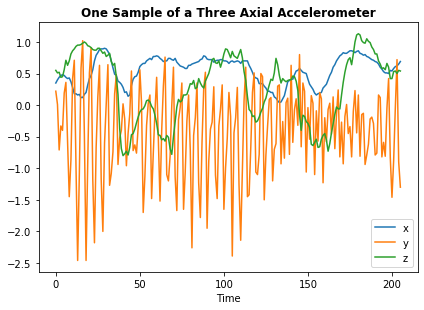

In [15]:
fig, axs = plt.subplots()
axs.plot(time,x_tuple, label='x')
axs.plot(time,y_tuple, label='y')
axs.plot(time,z_tuple, label='z')
plt.legend()
plt.tight_layout()
plt.title("One Sample of a Three Axial Accelerometer", weight='bold')
plt.xlabel("Time")

;

**What if that watch is slightly spun around the wrist? will the sample look completly different? lets look.**

In [16]:
# grabbing one sample again
x = np.reshape(x_tuple,(1,-1))[0]
y = np.reshape(y_tuple,(1,-1))[0]
z = np.reshape(z_tuple,(1,-1))[0]

In [18]:
x_45,y_45,z_45 = rotate_xyz(x,y,z,theta=45)

**Lets plot the sample in cartesian coordinants raw next to rotated for comparision**

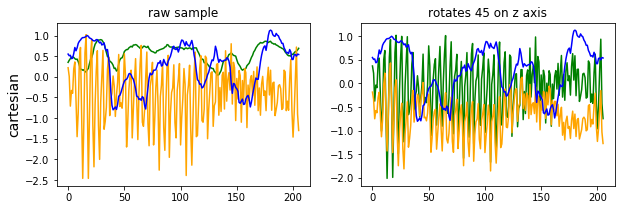

In [19]:
###ploting sample one with next to its self rotataed 45 arounf z_axis(wrist)
fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].plot(x,color="green")
axs[0].plot(y,color='orange')
axs[0].plot(z,color='blue')

axs[1].plot(x_45,color="green")
axs[1].plot(y_45,color='orange')
axs[1].plot(z_45,color='blue')

axs[0].set_ylabel('cartesian',size=14)
axs[0].set_title('raw sample')
axs[1].set_title('rotates 45 on z axis');
    

**There are big differences in the x and y if the acceleromter is twisted about the wrist (Z axis). I speculate that changing coordinant space to polar will eliminate some of the difference in acceleration patterns if the watch is spun. Lets look.**

In [23]:
#converting the first sample with no rotation from cartisian to polar
rho_raw,theta_raw,phi_raw = cart_to_polar(x,y,z)

In [24]:
# converting the same sample, but rotates 45 degrees about Z, from cartisian to polar
rho_45,theta_45,phi_45 = cart_to_polar(x_45,y_45,z_45)

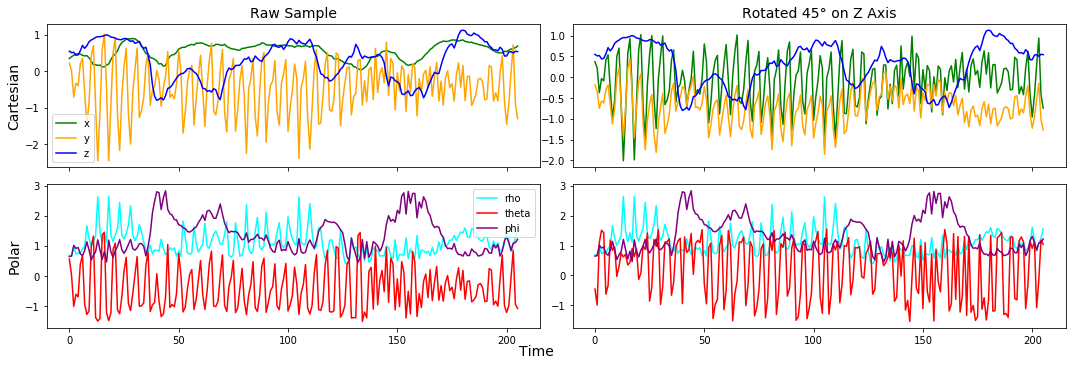

In [26]:
fig, axs = plt.subplots(2,2,figsize=(15,5),sharex=True)
axs[0][0].plot(x,color="green",label='x')
axs[0][0].plot(y,color='orange',label='y')
axs[0][0].plot(z,color='blue',label='z')
axs[0][0].legend()

axs[0][1].plot(x_45,color="green")
axs[0][1].plot(y_45,color='orange')
axs[0][1].plot(z_45,color='blue')

degree_sign = u"\N{DEGREE SIGN}"
axs[0][0].set_ylabel('Cartesian',size=14)
axs[0][0].set_title('Raw Sample',size=14)
axs[0][1].set_title(f'Rotated 45{degree_sign} on Z Axis',size=14)

axs[1][0].plot(rho_raw,color="cyan",label='rho')
axs[1][0].plot(theta_raw,color='red',label='theta')
axs[1][0].plot(phi_raw,color='purple',label='phi')
axs[1][0].legend()

axs[1][1].plot(rho_45,color="cyan")
axs[1][1].plot(theta_45,color='red')
axs[1][1].plot(phi_45,color='purple')

axs[1][0].set_ylabel('Polar',size=14)
fig.text(0.5, -.0, 'Time', ha='center',size=14)


plt.tight_layout()

#plt.savefig('../images/compare_coords_all.png')

**My clustering model will only work with one axial/channel. Since the equation to get the rho part of polar quardinance involves all catisian parts, x y and x, I will only use rho since it will encapsolate information from all directions.**

**Lets take a look**

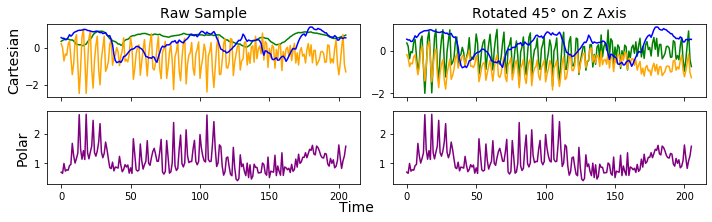

In [25]:
# plotting to see if my idea is correct
fig, axs = plt.subplots(2,2,figsize=(10,3),sharex=True)
axs[0][0].plot(x,color="green")
axs[0][0].plot(y,color='orange')
axs[0][0].plot(z,color='blue')

axs[0][1].plot(x_45,color="green")
axs[0][1].plot(y_45,color='orange')
axs[0][1].plot(z_45,color='blue')

degree_sign = u"\N{DEGREE SIGN}"
axs[0][0].set_ylabel('Cartesian',size=14)
axs[0][0].set_title('Raw Sample',size=14)
axs[0][1].set_title(f'Rotated 45{degree_sign} on Z Axis',size=14)

axs[1][0].plot(rho_raw,color="purple")
axs[1][1].plot(rho_45,color="purple")

axs[1][0].set_ylabel('Polar',size=14)
fig.text(0.5, -.0, 'Time', ha='center',size=14)

plt.tight_layout()

#plt.savefig('../images/compare_coords.png')

**The polar transformed sample does not look diffent when accelerometer is rotated 45 degrees, so I will make a new dataframe that is complety transformed into the rho part of polar coordinance.**

In [30]:
rho_df_train = df_to_rho(train_df)

../src/HAR_functions.py:39: RuntimeWarning: divide by zero encountered in true_divide
  def to_phi(x,y,z):


In [28]:
rho_df_train.shape

(137, 206)

In [31]:
type(rho_df_train)

numpy.ndarray

In [33]:
#saved

## EDA with clustering

**I would like to see if the seizure data is different enough from everyday tasks that it can be classified useing clustering.**

I am going to use a package from tslearn that does kmeans clustering on time series data.  The special part about this algorithm is it uses dynamic time warping (DTW) as the distance measure in the algorithm.<br>
<br>
DTW allows time series to be compaired even if the phase is shifted between samples. Also, it  allows  the model to retrieve a sensible average shape for a cluster centroid.<br>
<br>
general overview of DTW algorithm between two time series samples:<br>
<br>
>1. match indeces (warping map) <br>
each value of each time series is compaired to each other and "matched" to one another with the least difference between them, that satisied a certain set of rules:
  - Every index from the first sequence must be matched with one or more indices from the other sequence, and vice versa
  - The first index from the first sequence must be matched with the first index from the other sequence (but it does not have to be its only match)
  - The last index from the first sequence must be matched with the last index from the other sequence (but it does not have to be its only match)
  - The mapping of the indices from the first sequence to indices from the other sequence must be monotonically increasing, and vice versa.
2. warp/transform the second sample to be "warped" to match the first
3. now measure the distance between each step in the time series

more info https://tslearn.readthedocs.io/en/stable/user_guide/clustering.html 

**I am going to pretend that I do no know the number of labels in the target data and see how many clusteres the algorithm can pick up. Lets make an elbow plot to check for the number of clusters**

note: inertia = Sum of distances of samples to their closest cluster center. Lower is better but we can not just pick the number of clusters with the lowest inercia because your lowest inercia would be when k = n (it will get lower and lower with more cluster centroids) So you need to look for the k at the "elbow", between the steepest decrease in inercia and where the inercia only marginaly decreases.

In [40]:
import datetime

0:02:49.014234


''

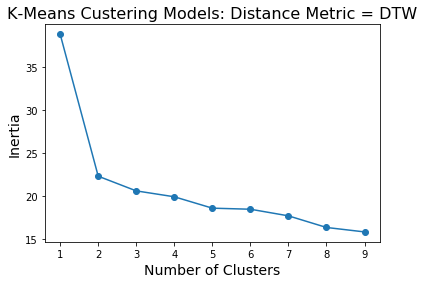

In [41]:
#warning: this cell takes a while to run 
inertias = []
t_start = datetime.datetime.now() 
for i in range(1,10):
    km = TimeSeriesKMeans(n_clusters=i,
                         metric='dtw',
                         random_state=666)
    km.fit(rho_df_train)
    inertias.append(km.inertia_)
plt.plot(range(1,10),inertias,marker='o')
plt.xlabel('Number of Clusters',size=14)
plt.ylabel('Inertia', size=14)
plt.title('K-Means Custering Models: Distance Metric = DTW',size=16)
#plt.savefig('../images/elbow_dtw.png')
t_end = datetime.datetime.now() 
print(t_end-t_start)
;

**Since we have the number of clusters narowed down to about 2, lets use the silhouette coefficience (sil score = average sil coef). this is not only a measure of how tight  the clusters are but how seperate from each other they are.**

In [43]:
#instanciating three models with 2, 3, and 4 clusters
km2 = TimeSeriesKMeans(n_clusters=2,
                         metric='dtw')
km3 = TimeSeriesKMeans(n_clusters=3, metric="dtw")

km4 = TimeSeriesKMeans(n_clusters=4, metric="dtw") 

In [44]:
#fitting them all with the same data the rho axial from the df
y_km2 = km2.fit_predict(rho_df_train)
y_km3 = km3.fit_predict(rho_df_train)
y_km4 = km4.fit_predict(rho_df_train)

In [46]:
# making cluster labels from the predictions
cluster_labels_2 = np.unique(y_km2)
cluster_labels_3 = np.unique(y_km3)
cluster_labels_4 = np.unique(y_km4)

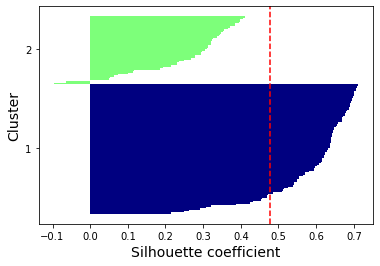

In [54]:
#compute the siluot coefficients for k = 2

make_sil_plot(rho_df_train,y_km2,metric=DTW,fitted_model=km2)

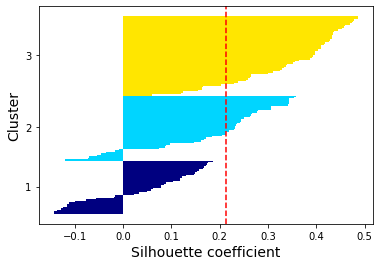

In [55]:
make_sil_plot(rho_df_train,y_km3,metric=DTW,fitted_model=km3)

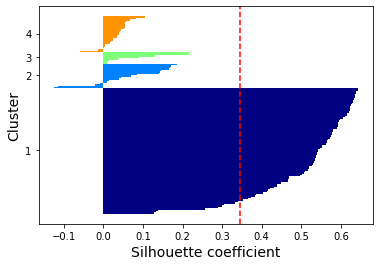

In [56]:
make_sil_plot(rho_df_train,y_km4,metric=DTW,fitted_model=km4)

note on siluette plots. if a sil coefficient is clse to +1, that means that instance is close to its cluster centroid and far from the other cluster centroids. a coefficient around 0 means that that instance is close to a cluster boundry, and a sil coefficient close to -1 means that it might be miss labeled to a cluster center. 

**This confirms that the best number of clusters is 2**

This makes me wonder if it is cluster siezure activity and non-seizure activity. lets look at the true labels and find out

In [59]:
true_labels = pd.DataFrame(train_df['activity'])

#making a column that is the predicted cluster assignment
true_labels['km2_pred'] = y_km2
labels_df = true_labels



which labels (0 or 1) was assigned to what action?

''

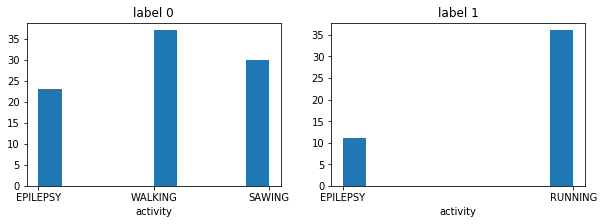

In [69]:
#just true epilepsy samples
#epilepsy = labels_df[labels_df['activity']==b'EPILEPSY']
label0 = labels_df[labels_df['km2_pred']==0]
label1 = labels_df[labels_df['km2_pred']==1]

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].hist(label0['activity'])
ax[0].set_title('label 0')
ax[0].set_xlabel('activity')

ax[1].hist(label1['activity'])
ax[1].set_title('label 1')
ax[1].set_xlabel('activity')

;

To my surprise It looks like the model is clustering out running and not running

In [71]:
#ratio of true epilepsy labels to each cluster
c0_ratio = epilepsy[epilepsy['km2_pred']==0].shape[0]/epilepsy.shape[0]
c0_ratio

0.6764705882352942

In [72]:
c1_ratio = epilepsy[epilepsy['km2_pred']==1].shape[0]/epilepsy.shape[0]
c1_ratio

0.3235294117647059

uh oh. looks like im clustering running, not-running

# THIS IS WHERE THINGS DIVERGE

_________________________________________________________________________________________________________

In [73]:
epilepsy_samples = rho_df_train[labels_df['activity']==b'EPILEPSY']

''

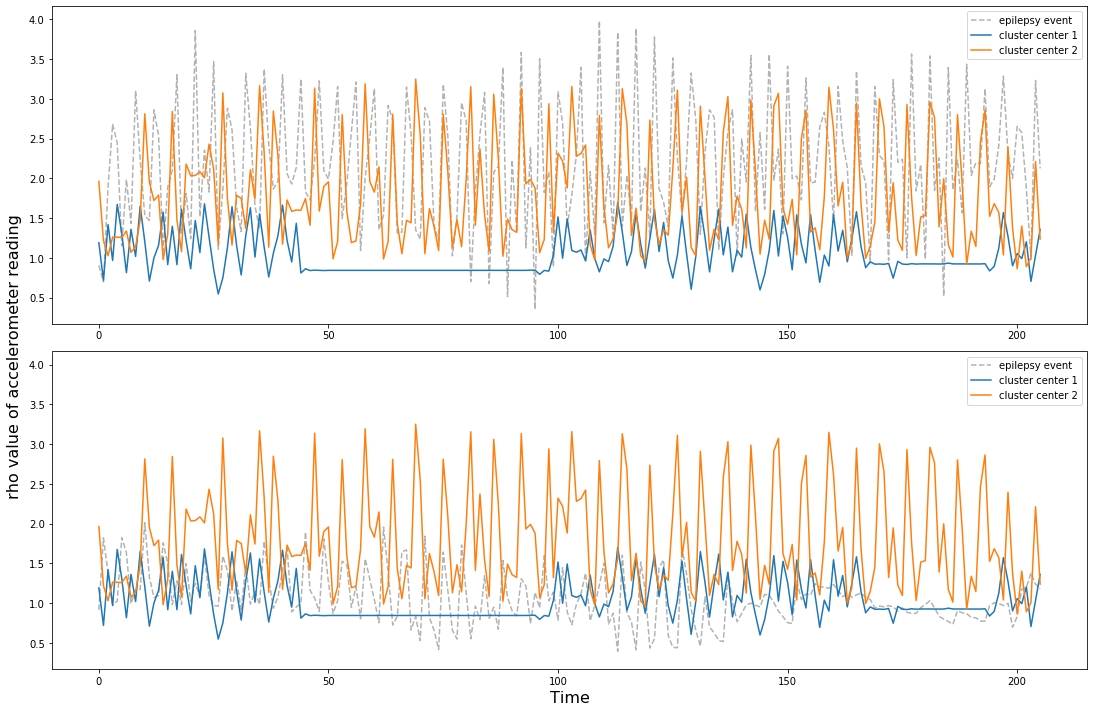

In [74]:
fig, axs = plt.subplots(2,1,figsize=(15,10),sharey=True)

axs[0].plot(epilepsy_samples[5],alpha=.3,color='k',linestyle='--',label='epilepsy event')
for i in range(2):
    axs[0].plot(km2.cluster_centers_[i],label=f'cluster center {i+1}')

axs[0].legend()

axs[1].plot(epilepsy_samples[1],alpha=.3,color='k',linestyle='--',label='epilepsy event')
for i in range(2):
    axs[1].plot(km2.cluster_centers_[i],label=f'cluster center {i+1}')  
    
fig.text(-0.01, 0.5, 'rho value of accelerometer reading', va='center', rotation='vertical',size=16)    
axs[1].set_xlabel('Time',size=16)
axs[1].legend()
plt.tight_layout()
#plt.savefig('../images/raw_series_comparison.png')
;

**this visualization reveals that my model might cluster better if i scale my data so that the model picks up on pattern as aposed to amplitude**

In [213]:
rho_df_normalized = np.empty((0,206))
for row in rho_df_train:

    row = np.reshape(row,(1,-1))

    rho_df_normalized = np.append(rho_df_normalized,row/np.max(row),axis=0)


In [200]:
rho_df_train.shape

(137, 206)

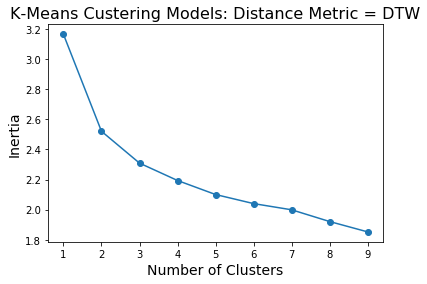

In [217]:
inertias = []                                                
for i in range(1,10):
    km = TimeSeriesKMeans(n_clusters=i,
                         metric='dtw',
                         random_state=666)
    km.fit(rho_df_normalized)
    inertias.append(km.inertia_)
plt.plot(range(1,10),inertias,marker='o')
plt.xlabel('Number of Clusters',size=14)
plt.ylabel('Inertia', size=14)
plt.title('K-Means Custering Models: Distance Metric = DTW',size=16)
#plt.savefig('../images/elbow_dtw_normalized.png')


**According to this elbow plot, normalization does not help the clustering model differensiate between seizure and non seizure**

**Below I am just taking a visual look at the normalized data**


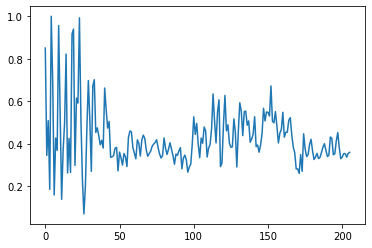

In [228]:
plt.plot(rho_df_normalized[labels_df['activity']==b'EPILEPSY'][3])

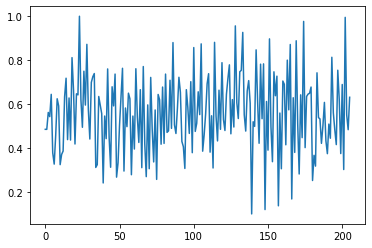

In [229]:
plt.plot(rho_df_normalized[labels_df['activity']==b'EPILEPSY'][10])

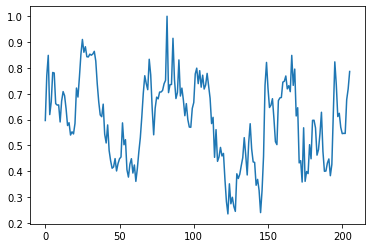

In [238]:
plt.plot(rho_df_normalized[labels_df['activity']==b'EPILEPSY'][6])

**lets try and do some feature extraction on the un normalized rho data instead**

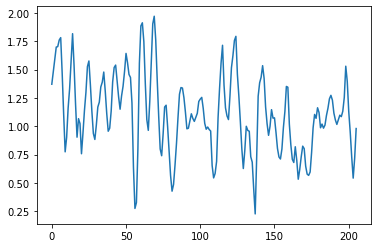

In [239]:
plt.plot(rho_df_train[labels_df['activity']==b'WALKING'][6])

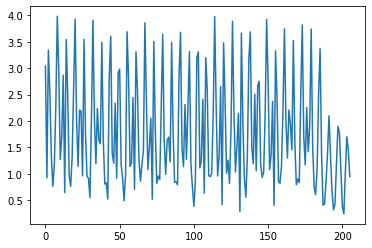

In [240]:
plt.plot(rho_df_train[labels_df['activity']==b'RUNNING'][6])

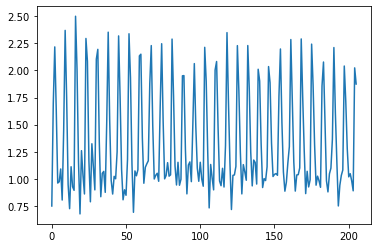

In [241]:
plt.plot(rho_df_train[labels_df['activity']==b'SAWING'][6])


**Although there is some clear pattern difference between normal activity and seizure activity, clustering does not differenciate them good enough to use as a model in real life. Lets move onto supervised  classification.**